# Get train and validation datasets to analysis
Собираю датасет для проверки различных гипотез и оценки вклада фич в результат


In [35]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt


dataset_path = './train/train_dataset.csv'

Получаем выборки: тусуем, делим в соотношении 90/10 - данных слишком мало

In [36]:
def fit_linear_regression(x_train, y_train, x_test):
    sgd = SGDRegressor(loss='huber', max_iter=1000)
    sgd.fit(x_train, y_train)
    return sgd, sgd.predict(x_train), sgd.predict(x_test)

def get_train_and_test_datasets(df, ratio=0.9):
    # Нормализация числовых полей
    df['StateHolidayDays'] = sklearn.preprocessing.normalize(df['StateHolidayDays'].values.reshape(-1, 1), axis=0)
    df['SchoolHolidayDays'] = sklearn.preprocessing.normalize(df['SchoolHolidayDays'].values.reshape(-1, 1), axis=0)
    df['Sales'] = sklearn.preprocessing.normalize(df['Sales'].values.reshape(-1, 1), axis=0)
    df['PromoDays'] = sklearn.preprocessing.normalize(df['PromoDays'].values.reshape(-1, 1), axis=0)
    df['Promo2DaysToNext'] = sklearn.preprocessing.normalize(df['Promo2DaysToNext'].values.reshape(-1, 1), axis=0)
    df['Promo2AllDays'] = sklearn.preprocessing.normalize(df['Promo2AllDays'].values.reshape(-1, 1), axis=0)
    df['Promo2Days'] = sklearn.preprocessing.normalize(df['Promo2Days'].values.reshape(-1, 1), axis=0)
    df['MeanByDay'] = sklearn.preprocessing.normalize(df['MeanByDay'].values.reshape(-1, 1), axis=0)
    df['Mean'] = sklearn.preprocessing.normalize(df['Mean'].values.reshape(-1, 1), axis=0)
    df['DayOfWeek'] = sklearn.preprocessing.normalize(df['DayOfWeek'].values.reshape(-1, 1), axis=0)
    df['DayOfMonth'] = sklearn.preprocessing.normalize(df['DayOfMonth'].values.reshape(-1, 1), axis=0)
    df['Customers'] = sklearn.preprocessing.normalize(df['Customers'].values.reshape(-1, 1), axis=0)
    df['CompetitionDistance'] = sklearn.preprocessing.normalize(df['CompetitionDistance'].values.reshape(-1, 1), axis=0)
    df['CompetitionDays'] = sklearn.preprocessing.normalize(df['CompetitionDays'].values.reshape(-1, 1), axis=0)
    # Работа с категориальными признаками
    objects = df.select_dtypes(include=[object])
    label_encoder = preprocessing.LabelEncoder()
    transf = objects.apply(label_encoder.fit_transform)
    enc = preprocessing.OneHotEncoder(categories='auto')
    enc.fit(transf)
    labels = enc.transform(transf).toarray()
    for i in range(0, labels.shape[1]):
        df[f'x{i}'] = pd.Series(labels[:,i])
    # Перемешиваем
    columns = list(df.columns)
    columns.remove('Sales')
    columns.remove('Assortment')
    columns.remove('StoreType')
    columns.remove('StateHoliday')
    x_train, x_test, y_train, y_test = train_test_split(df[columns], df['Sales'], test_size=1-ratio, random_state=123)
    # Добавляем линейную регрессию
    sgd, lr_train, lr_test = fit_linear_regression(x_train, y_train, x_test)
    x_train['x10'] = pd.Series(lr_train)
    x_test['x10'] = pd.Series(lr_test)
    return x_train, x_test, y_train, y_test

df = pd.read_csv(dataset_path, sep=',', index_col=False)
x_train, x_test, y_train, y_test = get_train_and_test_datasets(df)

# Metrics
Реализация собственного RMSPE для локальных тестов

In [37]:
def metrics(source, predict):
    count = np.min([source.shape[0], predict.shape[0]])
    mse = [(source[x] - predict[x]) ** 2 for x in range(0, count)]
    mse = np.sum(mse) / count
    return np.sqrt(mse)

# Fit Engineering
Выявляем значимые признаки

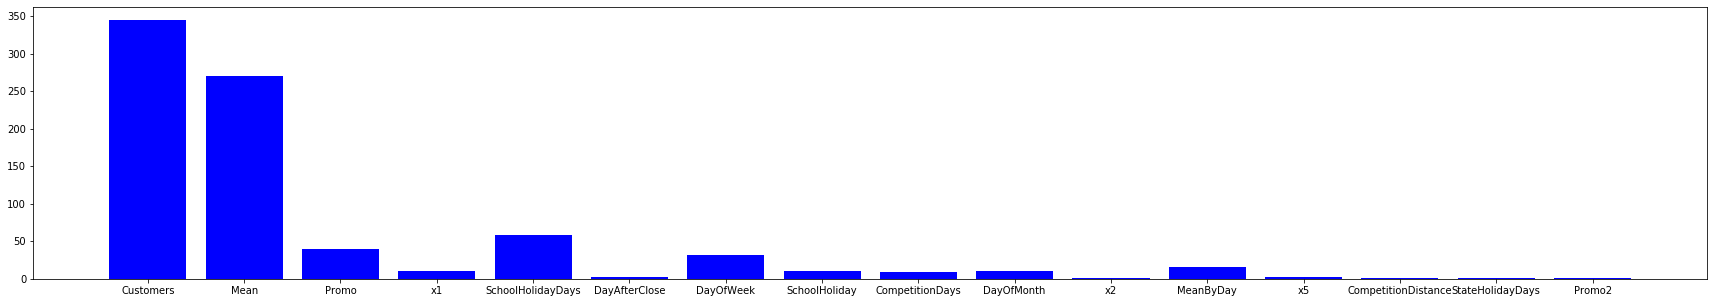

In [43]:
def get_feature_analyze_gb_model(x_train, y_train):
    gbm = xgboost.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=2, n_estimators=300, subsample=1, learning_rate=0.05, seed=300)
    gbm.fit(x_train, y_train)
    imps = gbm.get_booster().get_fscore()
    plt.figure(figsize=(30, 5))
    plt.bar(imps.keys(), imps.values(), color='b')
    plt.show()
    
get_feature_analyze_gb_model(x_train, y_train)

Оставляем Customers, Mean, Promo, ShcoolHolidayDays, DaysOfWeek и MeanByDay